#         PPV PREDICTIVE MODEL - UNITED STATES BUREAU OF MINES


At this notebook we are going to develop a script that finds optimal parameters K and B for the empiric formula to predict Peak Particle Values proposed by Wilbur I. Duvall at 1962. We'll use the Linear Least Square Error method with my own implementation of the Gradient Descent Algorithm.

$$ v= K*\left(\frac{R}{Q_{max}}\right)^{-B} $$

Where: <br> 
        &emsp;v = Peak Particle Velocity 
        <br>
        &emsp;R = Distance from measure point to blast site
        <br>
        &emsp;Q_max= Maximum Chanrge per Delay
        



First, We need to import some useful packages

In [1]:
#Numpy to matrix operations and data handling
import numpy as np
#Matplotlib to plot Learning Curves and Predictions
%matplotlib inline 
from matplotlib import pyplot as plt 
#Pandas for Data Loading
import pandas as pd
#Train_test_spli to split the data into Train and Test Sets
from sklearn.model_selection import train_test_split
#MSE and R2 metrics to evaluate the model's yield
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import r2_score

Loading the dataset from a .xlsx file 

In [2]:
file_name = "PPV_data"
main_path = ("D:\Desktop\Modelo Predictivo PPV\database")
file_path = (file_name + ".xlsx")
sheet_name = "data"
dataset = pd.read_excel(main_path + "\\" + file_path, sheet_name)

# Random Sampling a subset of 200 examples
dataset=dataset.sample(n=200,random_state=1)

Defining Features (X) and Labels (y)

In [3]:
# Panda's dataframe handling
X=dataset[["Distancia (m)","Kg de columna explosiva"]]
y=dataset["PPV"]

# Casting into numpy arrays
X=np.array(X,dtype=np.float64)
y=np.array(y,dtype=np.float64)

Splitting the data into Training and Test Sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3,shuffle=True)

#Reshaping 1D arrays into 2D arrays to aensure proper results while operating matrixes
y_train.shape, y_test.shape = (-1, 1), (-1, 1)

Here we must do some simple math to transform original formula into a linear model.
First, we have the original formula:

$$ v= K*\left(\frac{R}{Q_{max}}\right)^{-B} $$

Then, we apply a natural log to each site of the equation and follows log rules

$$ ln(v)= ln\left( K*\left(\frac{R}{Q_{max}}\right)^{-B}\right) $$
        <br>
$$ ln(v)= ln\left(K\right) + ln\left(\left(\frac{R}{Q_{max}}\right)^{-B}\right) $$
        <br>
$$ ln(v)= ln\left(K\right) -B * ln\left(\frac{R}{Q_{max}}\right) $$

Now we can solve as a linear regression problem, where we must learn parameters $\alpha$ and $\beta$ to fit the curve

$$ y = \alpha - \beta.X $$

Where:
$$y=ln(v)\\
X=ln\left(\frac{R}{Q_{max}}\right)$$

Then:
$$K= e^\alpha\\
B=-\beta$$




So, now we define a function to transform our data into the desire format

In [5]:
def USBM_transform(X,y):
    """
    Tansform a dataset into USBM format.

    Parameters
    ----------
    X (numpy.ndarray) : The independent variable 
    y (numpy.ndarray) : The dependent data

    Returns
    -------
    X_transformed (numpy.ndarray) : The independent variable transformed 
    y_transformed (numpy.ndarray) : The dependent data transformed

    """
    X_transformed=np.log(X[:,0]/np.sqrt(X[:,1]))
    y_transformed=np.log(y)
    X_transformed.shape, y_transformed.shape = (-1, 1), (-1, 1)
    
    return X_transformed , y_transformed

# It's just necessary to transform training data because we will fit the curve into this data.
X_train_transformed , y_train_transformed = USBM_transform(X_train, y_train)

# Adding an extra column of 1's to X in order to find intercept of the curve
X_train_transformed=np.concatenate((np.ones((len(y_train_transformed),1)),X_train_transformed),axis=1)



**Now we will implement Gradient Descent Algorithm from scratch**

Defining the Cost Function that allow us measure the yield of the current parameters 

In [6]:
def computeCost(X,y,theta):
    """
    Compute a variant of mean square error.
    
    Parameters
    ----------
    X (numpy.ndarray) : The independent variable 
    y (numpy.ndarray) : The dependent data
    theta (numpy.ndarray) : Parameters

    Returns
    -------
    J (float) : Cost

    """
    m=len(y)
    pred=X.dot(theta)
    sqrError=np.square(pred-y)
    J=(1/(2*m))*np.sum(sqrError)
    return J

Defining a Gradient Descent Function

In [7]:
def gradientDescent(X, y, theta, alpha=0.01, num_iters=100):
    """
    Gradient descent algorithm for linear models
    
    Parameters
    ----------
    X (numpy.ndarray) : The independent variable
    y (numpy.ndarray) : The dependent data
    theta (numpy.ndarray) : Parameters to optimize
    alpha (float) : Learning rate. The default is 0.01.
    num_iters (int) : Number of iterations. The default is 100.

    Returns
    -------
    theta (numpy.ndarray) : Optimized parameters
    J (list) : Cost history

    """
    m=len(y)
    J=[]
    for i in range(num_iters):
        error=X.dot(theta)-y
        delta=(1/m)*error.T.dot(X)
        theta=theta-(alpha*delta.T)
        J.append([computeCost(X,y,theta)])
    J=np.array(J)
    return theta , J

Setting initial values for theta, alpha and num_iters

In [8]:
initial_theta=np.ones((len(X_train_transformed[1]),1))
alpha=0.25
num_iters=500 

Optimizing the values of theta with Gradient Descent Function, and dumping results into respective variables

In [9]:
theta_found,J_history=gradientDescent(X_train_transformed,y_train_transformed,initial_theta,alpha,num_iters)

Plotting the Cost function as a function of the number of iterations

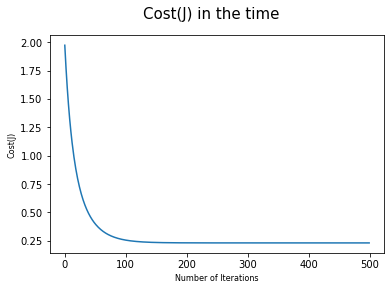

In [10]:
def plotCost(J_history):
    fig = plt.figure()
    plt.plot(J_history)
    fig.suptitle('Cost(J) in the time', fontsize=15)
    plt.xlabel('Number of Iterations', fontsize=8)
    plt.ylabel('Cost(J)', fontsize=8)
    
plotCost(J_history)


Retrieving values of K and B from theta_found

In [11]:
K=np.exp(theta_found[0])
B=-1*theta_found[1]

print("K value learned: {}".format(K))
print("B value learned: {}".format(B))

K value learned: [400.83917479]
B value learned: [1.30149609]


**Now we are ready to make predictions and measure the performance of the model**

In [12]:
def predict_USBM ( X , K , B ):
    """
    Predict values of Peak Particle Velocity given a dataset and constants K and B

    Parameters
    ----------
    X (numpy.ndarray) : Dependant variables. Where: X[:,0] = Distance from measure point to blast site and
                                                      X[:,1] = Maximun Charge per Delay
    K (float) : Site constant
    B (float) : Site constant

    Returns
    -------
    pred (numpy.ndarray) : Peak Particle Velocity Predictions

    """
    pred=K*((X[:,0]/X[:,1]**0.5)**(-B))
    return pred

pred_train=predict_USBM(X_train,K,B)
pred_test=predict_USBM(X_test,K,B)

Plotting Y_test values and Predicted Y_test Values

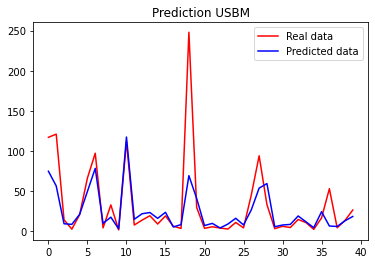

In [13]:
plt.figure()
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(pred_test, color = 'blue', label = 'Predicted data')
plt.title('Prediction USBM')
plt.legend()
plt.show()

Evaluating the model

In [14]:
print("Root Mean Square Error in the Train Set: {:.2f}".format(MSE(y_train,pred_train)**(1/2)))
print("Root Mean Square Error in the Test Set: {:.2f}\n".format(MSE(y_test,pred_test)**(1/2)))

print("Coefficient of Determination R2 in the Train Set: {:.2f}".format(r2_score(y_train,pred_train)))
print("Coefficient of Determination R2 in the Test Set: {:.2f}".format(r2_score(y_test,pred_test)))

Root Mean Square Error in the Train Set: 31.00
Root Mean Square Error in the Test Set: 33.30

Coefficient of Determination R2 in the Train Set: 0.54
Coefficient of Determination R2 in the Test Set: 0.53


It's important to mention that this could be achieve easily with an specialiazed package like Linear Regression from SKLearn or curve_fit from Scipy. However, this implementation allows the reader to understand the math behind optimization algorithms like gradient descent.